# Schelling's segregation model

This example is taken from `Agents.jl` [tutorial](https://juliadynamics.github.io/Agents.jl/stable/examples/schelling/).

- Agents : They belong to one of two groups (0 or 1).
- Model : Each position of the grid can be occupied by at most one agent.
- For each step
  - If an agent has at least 3 neighbors belonging to the same group, then it is happy.
  - If an agent is unhappy, it keeps moving to new locations until it is happy.

To define an agent type, we should make a mutable struct derived from `AbstractAgent` with 2 mandatory fields:
- `id::Int` . The identifier number of the agent.
- `pos` . For agents on a 2D grid, the position field should be a tuple of 2 integers.

On top of that, we could define other properties for the agents.

```julia
mutable struct SchellingAgent <: AbstractAgent
    id::Int             # The identifier number of the agent
    pos::NTuple{2, Int} # The x, y location of the agent on a 2D grid
    mood::Bool          # whether the agent is happy in its position. (true = happy)
    group::Int          # The group of the agent, determines mood as it interacts with neighbors
end
```

## Setup

First, we create a 2D space with a Chebyshev metric. This leads to *8 neighboring positions* per position (except at the edges of the grid).

In [1]:
using Agents

# Creating a space
space = GridSpace((10, 10); periodic = false)

GridSpace with size (10, 10), metric=chebyshev, periodic=false

We define the Agent type using the [`@agent`](https://juliadynamics.github.io/Agents.jl/stable/api/#@agent-macro-1) macro. Thus we don't have to setup the mandatory `id` and `pos` fields by ourselves. The relevant fileds are `mood` (whetehr the agent is happy or not) and `group` (which group the agent is on).

In [2]:
@agent SchellingAgent GridAgent{2} begin
    mood::Bool  # True = happy
    group::Int  # 0 or 1
end

In [3]:
properties = Dict(:min_to_be_happy => 3) # Parameter for the ABM

schelling = ABM(SchellingAgent, space; properties)
# schelling2 = ABM(SchellingAgent, space; properties = properties, scheduler = Schedulers.by_property(:group),)  # Custom scheduler

AgentBasedModel with 0 agents of type SchellingAgent
 space: GridSpace with size (10, 10), metric=chebyshev, periodic=false
 scheduler: fastest
 properties: min_to_be_happy

We setup the model using an `initialize()` function to make the model easier to reproduce and change its parameter(s).

In [4]:
using Random # for reproducibility in the RNG

function initialize(; numagents = 320, griddims = (20, 20), min_to_be_happy = 3, seed = 125)
    space = GridSpace(griddims, periodic = false)
    properties = Dict(:min_to_be_happy => min_to_be_happy)
    rng = Random.MersenneTwister(seed)
    model = ABM(
        SchellingAgent, space;
        properties, 
        rng, 
        scheduler = Schedulers.randomly
    )

    # populate the model with agents, adding equal amount of the two types of agents
    # at random positions in the model
    for n in 1:numagents
        agent = SchellingAgent(n, (1, 1), false, n < numagents / 2 ? 1 : 2)
        add_agent_single!(agent, model)  # We don't need to set the starting position. Agents package chooses randomly for us.
    end
    return model
end

initialize (generic function with 1 method)

Finally, we define a step function `agent_step!()` to determine what happens to each agent. We use some built-in functions: `nearby_agents()` and `move_agent_single!()`.

In [5]:
function agent_step!(agent, model)
    minhappy = model.min_to_be_happy
    count_neighbors_same_group = 0
    # For each neighbor, get group and compare to current agent's group
    # and increment count_neighbors_same_group as appropriately.
    # Here `nearby_agents` (with default arguments) will provide an iterator
    # over the nearby agents one grid point away, which are at most 8.
    for neighbor in nearby_agents(agent, model)
        if agent.group == neighbor.group
            count_neighbors_same_group += 1
        end
    end
    if count_neighbors_same_group ≥ minhappy
        # The agent is happy
        agent.mood = true
    else
        # Move the agent to a random position
        move_agent_single!(agent, model)  
    end
    return
end

agent_step! (generic function with 1 method)

## Stepping the model

In [6]:
model = initialize()

AgentBasedModel with 320 agents of type SchellingAgent
 space: GridSpace with size (20, 20), metric=chebyshev, periodic=false
 scheduler: randomly
 properties: min_to_be_happy

The `step!()` function moves the model forward. `run!()` is similar to `step!()` but also collects data along the simulation.

In [7]:
# Move the model by one iteration
step!(model, agent_step!)

In [8]:
# Move the model by 3 iterations
step!(model, agent_step!, 3)

## Visualization

The `abm_plot()` function visulizes the simulation result. By default `Makie.jl` is used.

In [9]:
using InteractiveDynamics
using CairoMakie            # Makie with the Cario backend

# Some helper functions to identify agent groups.
groupcolor(a) = a.group == 1 ? :blue : :orange
groupmarker(a) = a.group == 1 ? :circle : :rect

groupmarker (generic function with 1 method)

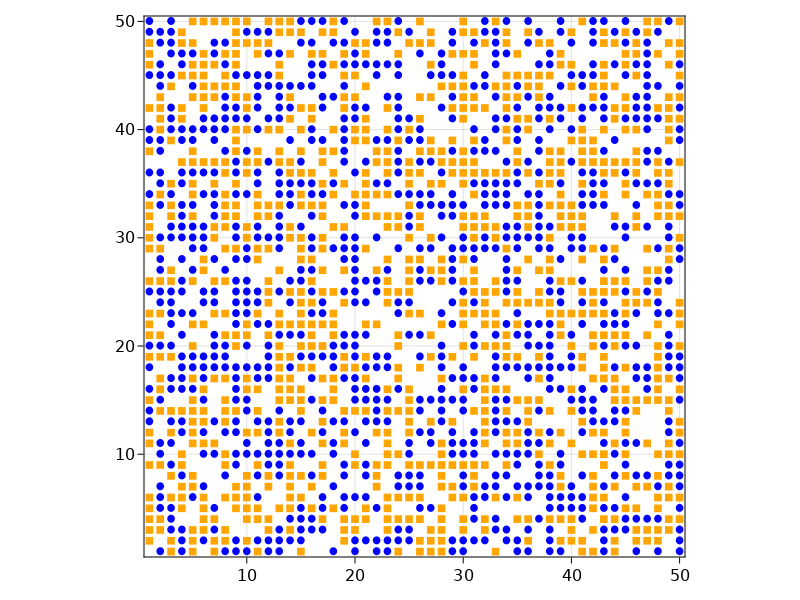

In [10]:
model = initialize(griddims = (50, 50), numagents = 1800)
figure, _ = abmplot(model; ac = groupcolor, am = groupmarker, as = 10)
figure  # The static figure

Let's make the simulation move. Since there is not `IPython.video()` analog in IJulia, 

In [11]:
model = initialize(griddims = (50, 50), numagents = 1800)

abmvideo(
    "schelling.mp4", model, agent_step!;
    ac = groupcolor, am = groupmarker, as = 10,
    framerate = 4, frames = 20,
    title = "Schelling's segregation model"
)

In [12]:
using Base64

function display_mp4(filename)
    display("text/html", string("""<video autoplay controls><source src="data:video/x-m4v;base64,""",
        Base64.base64encode(open(read, filename)),"""" type="video/mp4"></video>"""))
end

display_mp4("schelling.mp4")

<source src="data:video/x-m4v;base64,AAAAIGZ0eXBpc29tAAACAGlzb21pc28yYXZjMW1wNDEAAAAIZnJlZQAFTABtZGF0AAACoAYF//+c3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MyAtIEguMjY0L01QRUctNCBBVkMgY29kZWMgLSBDb3B5bGVmdCAyMDAzLTIwMjEgLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwgLSBvcHRpb25zOiBjYWJhYz0xIHJlZj01IGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMgbWU9aGV4IHN1Ym1lPTggcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5nZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTIgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEgZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz0xOSBsb29rYWhlYWRfdGhyZWFkcz0zIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFjZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJhbWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0zIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdlaWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49NCBzY2VuZWN1dD00MCBpbnRyYV9yZWZyZXNoPTAgcmNfbG9va2FoZWFkPTUwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjAuMCBxY29tcD0wLjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAACPmtliIQAFP/+99S3zLLtDB22C6j3op4mX0N1JQGblsTtOoAAAAMAAAMAAKLUhLwbbj8GijvAAV+29P/bFIAVJN5B9JPRVFWzInf08Ux82sprk1ZRZ38ZTQmKsCikybPCzo4rLlrX4yyN8HbCiGutlRtznpzaYDH19IrZKEN7mVZ8KVBWdBaEfmbsUTlWE5lHQAFIr37RYmeDYU+DxffF80ObkZzIKx/W11u2J3n6BC4qkMreLCe3hWp4kuE3Bw0XviZKb5O5y42LonBn5tATn0UieT6HKpppuGs9WdL/WRQTEpm/+7PfnTwigIaalC6ZxWC3RylsOczBXRT9GLl+q/N3k7CC1KCdtdy7COBUoPtYp/RL/nEIDVvByHGbkqPTnWvrRzTBX+YIpBn7hb44rsuzhB312UTFSDcWXJx68ZIDv2b03wDiBHoXST0f1PBVZ/uNInBB6Yat3mfzM+BRkdRPJlFyP0MzWXfRQufdiZhBBF2cqEGO641CE3NS//Yvwq+pwJdAGV9iSyLX5d0rKpLRZQcNscWjsqaFqGafy2eI6pOTlyTsQWtAuFVl39ppFFENQa6wouVVvStRl+FQyez9FtRzzv3lu/ik2nOgtMZrhlekuZvG26FRGrlKU6j8FjOK7kK1YlVGn5jmQEISirXJTOy5Bk8det0sXpOoUztf8GhuOqvO3ez0cWxyMSjsDSt5WAWehVsel2QEmn221FcjA73DRtrU7/yBkSC4aTBhvujvVFOFOaBRhbBCtWYcCgsyLWu+fXsXc7cFr/zIQirWcBWZxAcpqYLTA4sHTNakQXm8ybXLeQiq3pXvBIKsfQqma4ItlIYh8Yxj5IXgxhJ12FweeXwe7MSJZXQB4gMdSE1tVkq4E+5Lad6dN2XgAAzSa6+2oBrV+XB4a6w8D2OMFkKDLz0n+nYZcsV6N1qODTi1q8DosKWvgT6TwYwXB4h7sWHlf0Srr7lqov62AZNGi/JlTNEzEOZEZ0dceW9cZZxRgBdPsGK4kKpnf0sm7QXzOgS1ewyKa+SA4CfJNA4CPkjaLWqUcp8wSO58OUFA+FJ9pBvchbrunTzTqRxC1qYydP3AwQo2R0B0rbOPN2/BGK83O//6EFSS4+INCKDrwVEmS2JPKVMfM5OmqQkclkaZtEny6jGDFoofO7hLT8HcBts5y7G20TA17oTmsl9ZGvRzWIxUhWKpav3c6GZy5nOs3fB2Yg8UiNdowp3abBflUvd0p3muPnLgbzS0BaLNbxIluLzcgIcjaVq7VtWFkyzoKFEGaU+xj+XIeadvSUdZYnK/EseyjuqBv6dwf4+mSVsxlZK6xoJfmlRwf/9dAtZw3xPS2t2uyB44uTR4Jjg1T9GeNBhHeVogzJuRGag9BSBdVViqdHsSjk/nYLVCO0zcl8XuaR09lheGKwXWhlwomBdW2Wsu9darG57H2KlhCPXxq0TUSPlQHJjZkTprCOM8gtC7Fw0+nJ4jwL4x8FW7TjXFHeOB5PiINv4iOsjtC3zVysb+3xyUbtzaHMH8+1JVCbqf3JPTKrBVOmBcGNJBtlOI+fmZBtf9GQgNxVzI3LDKM8z+pPFJiAdo+Mbvne/nCLDO0VBSGVlVNtf0mMiy0lwADsZWPhfrbNOuYmSLs5+Iwg6yCXgkx/xVeCTgeCBb5TwshBpGwMLkwON2hRSEvIw4lt2lzk+XQrOiLJPliCJHnAAOmWtPPnifd35Uxm8HwanoPGfGml247E9YCgtvtWOKCIYGa1o7P6bdhi5Hynl97Gshw9U0oSV8951lDvX7ff3Fs/dckXsy4QAXfUVqFGApQWj0wH9Ire7fylq5Bs1GjbSWCeQOphk0sn4Mkc6jj51m3l/UZ3jGyPcx9zXv3UvQZh8i3nbi1wHonZVMAeHG3mt6bH0MyBMwiwF52cu+0BBPqR4mzefAmjUKXC3Qvuk+SMUawcZH1kSGBPfZngO/nK4ZPqWxMfBCyqbcdcRZZgBRv0/sjtO8pU35vehXdGx/ErKqCjBbPfOkrdOeOItXRFpiI5rKqHs1ADd3JO/SrI/UH7xkNtNnPV6SUR/q8w9geNQKSIqF981YJ6P1JhPZHMHq5HYF5lXqWXsAFNucL4uLAT5rgSO30DPJGxYI9uJ98PiHmvnu0FyUPEyEdyrv9L9jB12wemRYA6pfzBm8q3cZkd6u/88hDLV5tmgefF0stSxSJgneKS6bVfcujFvc00Www0FRXg+j1ZYonPmQyNh6sayaRub1h7K8ILW1l1hST6MawzCHlv4t8DmOk6D9D/mSsh5AZJvARIpccM0xMj6qFed+ptlQQhGtrLmOSlPKK7eUyxo3JneO/WErbAT9goepE/7HVsX8gXBzjBxWXU9CSf+z4TnRi1rukqKuPjD1TM9egh2VlH2TTB/fAzFVyMVOWsxjkRZu819kxQWPlpamHtvECDJrAKuGD0tLJYEbyu7mRbL0+WCg7ipuXYymCx1uqRK3I/z7MLkrtqrqBEc1qL729DSrB0e07LB03mV6DkebszRbGo/hAb6B/ucZVE0sNlNEVSQ/LnEUPdp5G+ydxPda9sM9Z8oo7H1d5tAMAoy5Z3WIMDAB71u48AF9bVsmvtZe2F05ihiVVuF6lLrLoYCark0ikuSODKXg+dFQ62i6zvzNXFP17IZXmQgU1Awv6iuu7xHXzwMMkR9Km+AXqhMe/cCRXjrRDQfCG4a8ndkcP8QX5edrAXrjn1K5LU9UW6foRKWi3cviH1vPQsoc4+gmedp7kcc2zLjuSEvIhSOKAu9SEUWjn0WApDhihC2zVp1Uyhex8NtWJqifFCsiBwXnGhdd1U0bf4wxfQv0tD8wPATcW5L/Dg7zXdfZeuWtn6DQ89nmwsH9OobmMW+w+1/taBi4Ii8JWS66dEwVodhHUhK2yrMx8S1ra/JNKMCOVZWxRB/cFxl0+EdwgkDvGx/jRdoHc2PfyPfFkyPcaOpkl1Zg5qRBB+7AHpCZuxA

## Data analysis

The `run!()` function rusn simulation and collects data in the `DataFrame` format. The `adata` (aggregated data) keyword extacts information in the DataFrame.

In [13]:
# aggregated data. fields we want to extract
adata = [:pos, :mood, :group]

model = initialize()
data, _ = run!(model, agent_step!, 5; adata)
data[1:10, :] # print only the first 10 rows

,step,id,pos,mood,group
,Int64,Int64,Tuple…,Bool,Int64
1,0,1,"(14, 19)",0,1
2,0,2,"(14, 10)",0,1
3,0,3,"(7, 11)",0,1
4,0,4,"(1, 16)",0,1
5,0,5,"(2, 13)",0,1
6,0,6,"(6, 3)",0,1
7,0,7,"(20, 14)",0,1
8,0,8,"(14, 5)",0,1
9,0,9,"(15, 20)",0,1


In [14]:
# adata also accepts functions
x(agent) = agent.pos[1]
model = initialize()
adata = [x, :mood, :group]
data, _ = run!(model, agent_step!, 5; adata)
data[1:10, :]

,step,id,x,mood,group
,Int64,Int64,Int64,Bool,Int64
1,0,1,14,0,1
2,0,2,14,0,1
3,0,3,7,0,1
4,0,4,1,0,1
5,0,5,2,0,1
6,0,6,6,0,1
7,0,7,20,0,1
8,0,8,14,0,1
9,0,9,15,0,1


## Launching an interactive app

See [this section](https://juliadynamics.github.io/Agents.jl/stable/examples/schelling/#Launching-the-interactive-application-1) using `abm_data_exploration()` in the official tutorial.

## Saving the model state

- `AgentsIO.save_checkpoint()`
- `AgentsIO.load_checkpoint()`

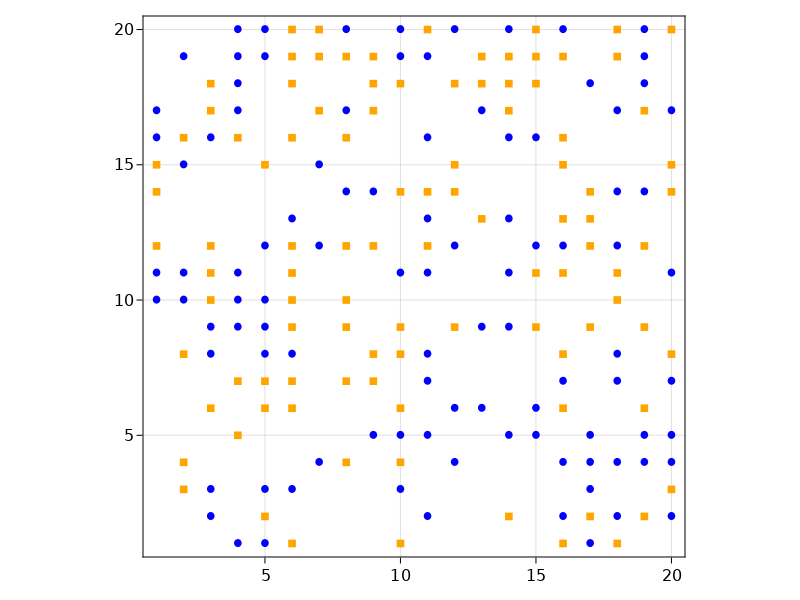

In [15]:
model = initialize(numagents = 200, min_to_be_happy = 5, seed = 42)

run!(model, agent_step!, 40)

figure, _ = abmplot(model; ac = groupcolor, am = groupmarker, as = 10)
# State after 40 steps
figure

In [16]:
# Save the model state (to be loaded later)
# jld2 as to Julia is "pickle" as to Python
AgentsIO.save_checkpoint("schelling.jld2", model)

In [17]:
# Load the model
model = AgentsIO.load_checkpoint("schelling.jld2"; scheduler = Schedulers.randomly)

AgentBasedModel with 200 agents of type SchellingAgent
 space: GridSpace with size (20, 20), metric=chebyshev, periodic=false
 scheduler: randomly
 properties: min_to_be_happy

In [18]:
# Mees with this model by adding more blue agents
for i in 1:100
    agent = SchellingAgent(nextid(model), (1, 1), false, 1)
    add_agent_single!(agent, model)
end

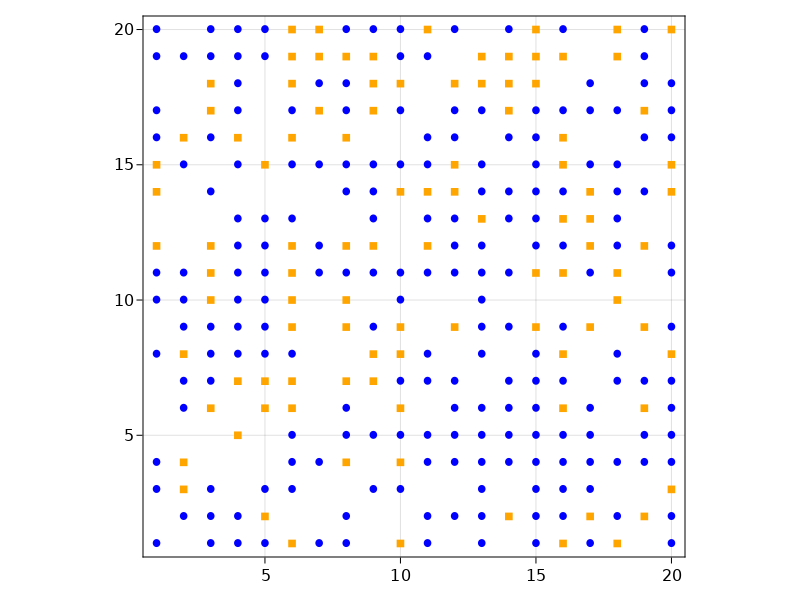

In [19]:
figure, _ = abmplot(model; ac = groupcolor, am = groupmarker, as = 10)
figure

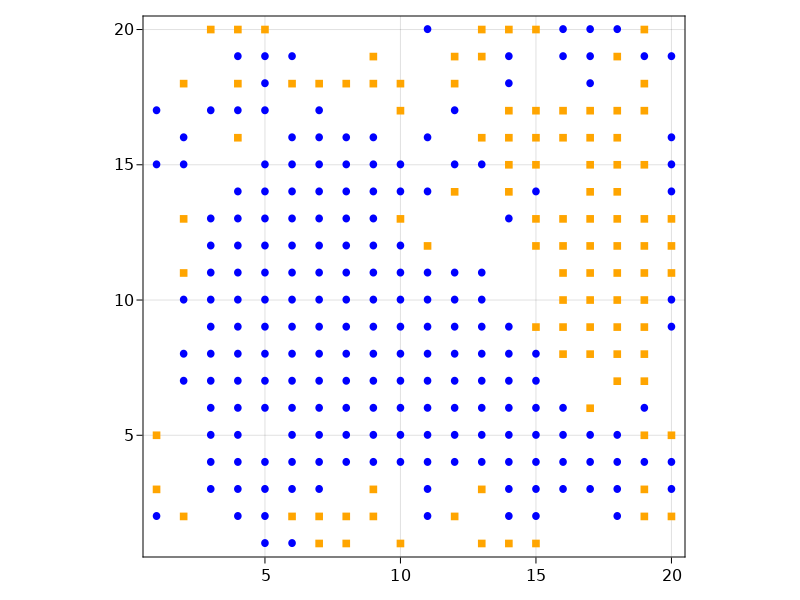

In [20]:
step!(model, agent_step!, 40)

figure, _ = abmplot(model; ac = groupcolor, am = groupmarker, as = 10)
figure

And let's try what happens if we add one more group (green) of agents.

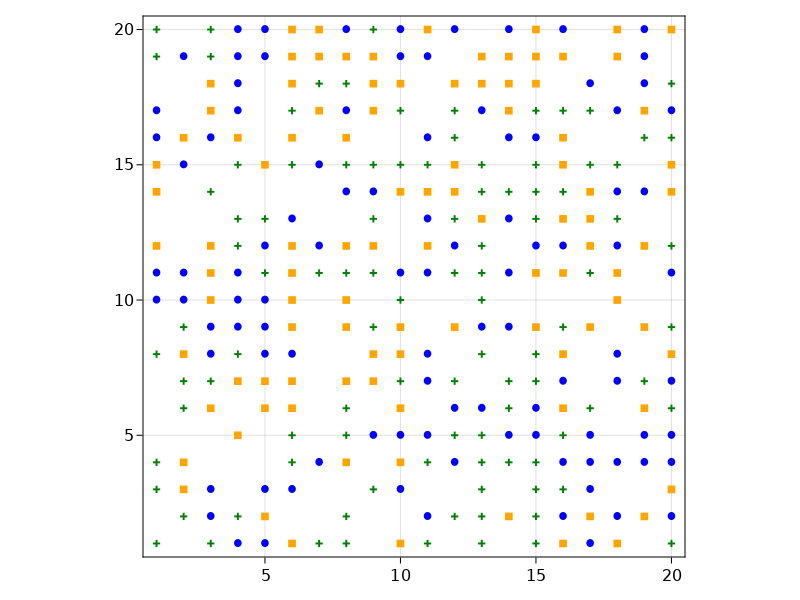

In [21]:
model = AgentsIO.load_checkpoint("schelling.jld2"; scheduler = Schedulers.randomly)

for i in 1:100
    agent = SchellingAgent(nextid(model), (1, 1), false, 3)
    add_agent_single!(agent, model)
end

groupcolor(a) = (:blue, :orange, :green)[a.group]
groupmarker(a) = (:circle, :rect, :cross)[a.group]

figure, _ = abmplot(model; ac = groupcolor, am = groupmarker, as = 10)
figure

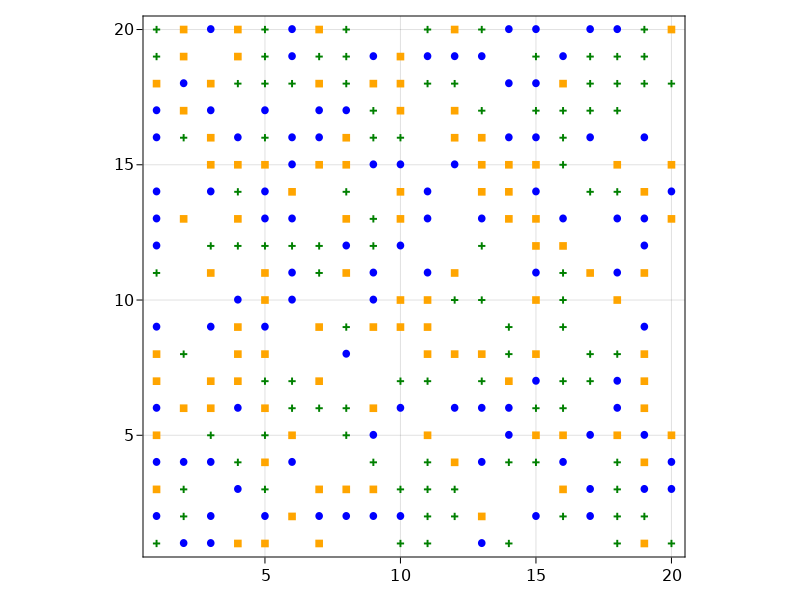

In [22]:
step!(model, agent_step!, 40)

figure, _ = abmplot(model; ac = groupcolor, am = groupmarker, as = 10)
figure